In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp2d
import os

pd.set_option('max_columns', None)
pd.set_option('max_rows', 120)

# for visualising the matrices
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

In [2]:
import xGils.xLoad as xLoad
import xGils.xT as xT

In [3]:
output_data_repo = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Original Opta xT'

# **Loading Opta data**

**4 Seasons of Data:**
1. 17/18 season (City winners, United 2nd)
2. 18/19 season (City winners, Liverpool 2nd)
3. 19/20 season (Liverpool winners, City 2nd)
4. 20/21 season (City winners, United 2nd)

In [4]:
df_opta_1718 = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Opta/EPL Data/Events/df_subevents_EPL_1718.csv')
df_opta_1819 = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Opta/EPL Data/Events/df_subevents_EPL_1819.csv')
df_opta_1920 = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Opta/EPL Data/Events/df_subevents_EPL_1920.csv')
df_opta_2021 = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Opta/EPL Data/Events/df_subevents_EPL_2021.csv')

df_opta_1718_cl = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Opta/CL Data/Events/df_subevents_CL_1718.csv')
df_opta_1819_cl = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Opta/CL Data/Events/df_subevents_CL_1819.csv')

df_opta_1718['competition'] = 'English Premier League'
df_opta_1819['competition'] = 'English Premier League'
df_opta_1920['competition'] = 'English Premier League'
df_opta_2021['competition'] = 'English Premier League'

df_opta_1718_cl['competition'] = 'Champions League'
df_opta_1819_cl['competition'] = 'Champions League'

df_opta_1718['season'] = '2017/18'
df_opta_1819['season'] = '2018/19'
df_opta_1920['season'] = '2019/20'
df_opta_2021['season'] = '2020/21'

df_opta_1718_cl['season'] = '2017/18'
df_opta_1819_cl['season'] = '2018/19'

df_opta_1718['seasonIndex'] = 1
df_opta_1819['seasonIndex'] = 2
df_opta_1920['seasonIndex'] = 3
df_opta_2021['seasonIndex'] = 4

df_opta_1718_cl['seasonIndex'] = 1
df_opta_1819_cl['seasonIndex'] = 2

df_opta = pd.concat([df_opta_1718, df_opta_1819, df_opta_1920, df_opta_2021, df_opta_1718_cl, df_opta_1819_cl])

# **Loading Synthetic Shot Data**

In [5]:
df_synthetic = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Synthetic/Synthetic_Shots.csv')

## Defining Opta action event buckets

Splitting actions / events into buckets for:
* Successful pass events;
* Unsuccessful pass events;
* Successful dribble events;
* Unsuccessful dribble events;
* Successful shot events;
* Unsuccessful shot events.

In [6]:
# pass events (inc. crosses)
opta_successful_pass_events = ['2nd Assist','Assist','Chance Created','Cross','Pass']
opta_failed_pass_events = ['Failed Pass','Offside Pass']

# dribble events
opta_successful_dribble_events = ['Dribble']
opta_failed_dribble_events = ['Failed Dribble']

# shot events
opta_successful_shot_events = ['Goal']
opta_failed_shot_events = ['Hit Woodwork','Miss','Missed Penalty','Penalty Saved','Shot Blocked','Shot Saved']

In [7]:
opta_events_relevant = opta_successful_dribble_events + opta_successful_pass_events + opta_successful_shot_events + opta_failed_dribble_events + opta_failed_pass_events + opta_failed_shot_events

opta_events_relevant

['Dribble',
 '2nd Assist',
 'Assist',
 'Chance Created',
 'Cross',
 'Pass',
 'Goal',
 'Failed Dribble',
 'Failed Pass',
 'Offside Pass',
 'Hit Woodwork',
 'Miss',
 'Missed Penalty',
 'Penalty Saved',
 'Shot Blocked',
 'Shot Saved']

# Feature Engineering

1. Converting string datetime fields -> datetime
1. Inferring the end coords of Opta dribble events
1. Transforming Opta coords to metres for a given pitch size

# **Applying Tranformation Equations**

In [8]:
%%time

df_opta = xLoad.apply_datetimes(df_opta)
df_opta = xLoad.create_game_month_index(df_opta)
df_opta = xLoad.opta_infer_dribble_end_coords(df_opta)
df_opta = xLoad.coords_in_metres(df_opta, 'x1', 'x2', 'y1', 'y2')

CPU times: user 4min 24s, sys: 9.82 s, total: 4min 34s
Wall time: 4min 34s


---

# **xT**


In [9]:
N, M = 18, 12

## 1) Looking at some of the xT components first, before putting it all together

### Matrix Visualisation

#### xG **WITHOUT** synthetic shots/goals

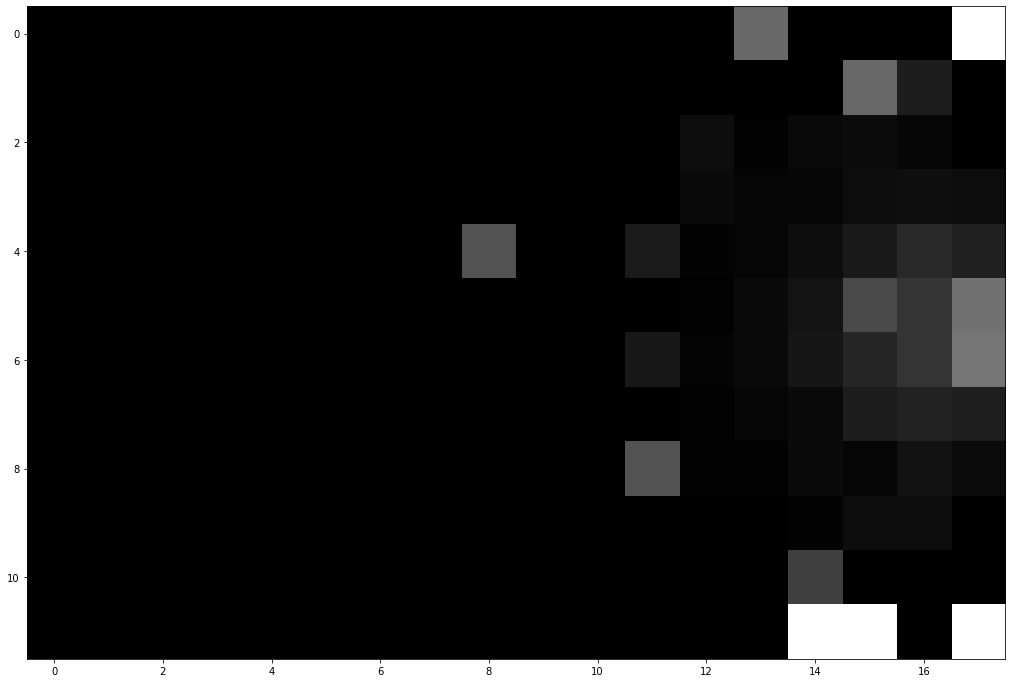

In [10]:
xG = xT.p_score_if_shoot(df_opta, opta_successful_shot_events, opta_failed_shot_events, 'eventSubType', N, M, 105, 68)

fig = plt.figure(figsize=(18,12))
plt.imshow(xG, interpolation='nearest', cmap=cm.Greys_r)

#### xG **WITH** synthetic shots/goals

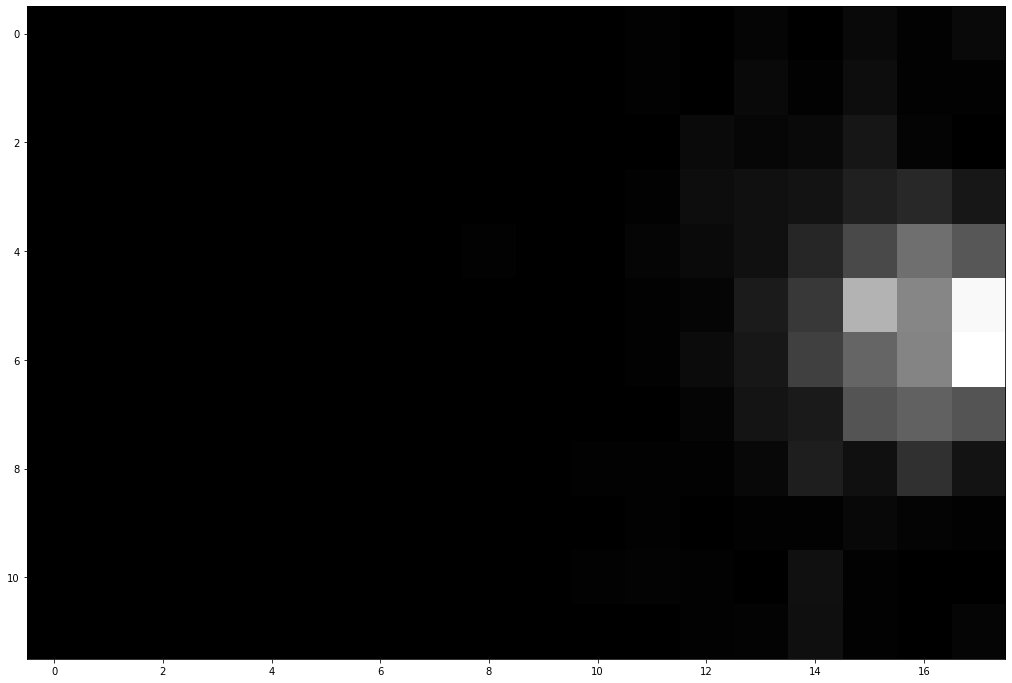

In [11]:
xG = xT.p_score_if_shoot(df_opta, opta_successful_shot_events, opta_failed_shot_events, 'eventSubType', N, M, 105, 68, use_synthetic=1, df_synthetic=df_synthetic)

fig = plt.figure(figsize=(18,12))
plt.imshow(xG, interpolation='nearest', cmap=cm.Greys_r)

#### Probability of shooting

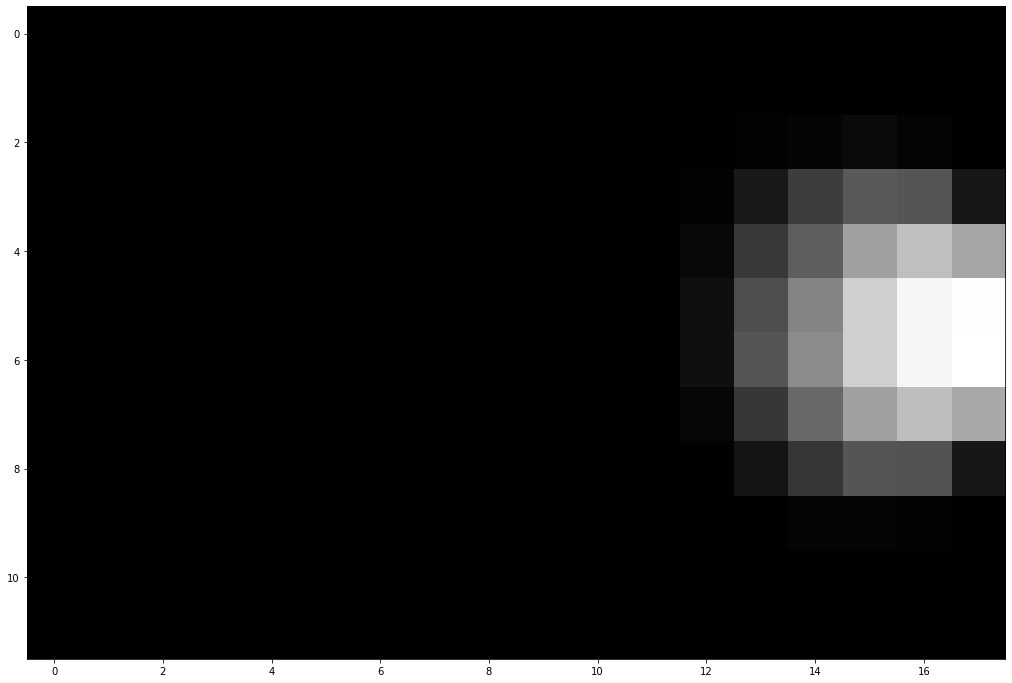

In [12]:
pS, pM = xT.p_shoot_or_move(df_opta, opta_successful_shot_events, opta_failed_shot_events, opta_successful_pass_events, opta_failed_pass_events, opta_successful_dribble_events, opta_failed_dribble_events, 'eventSubType', N, M, 105, 68)

fig = plt.figure(figsize=(18,12))
plt.imshow(pS, interpolation='nearest', cmap=cm.Greys_r)

#### Probability of Moving

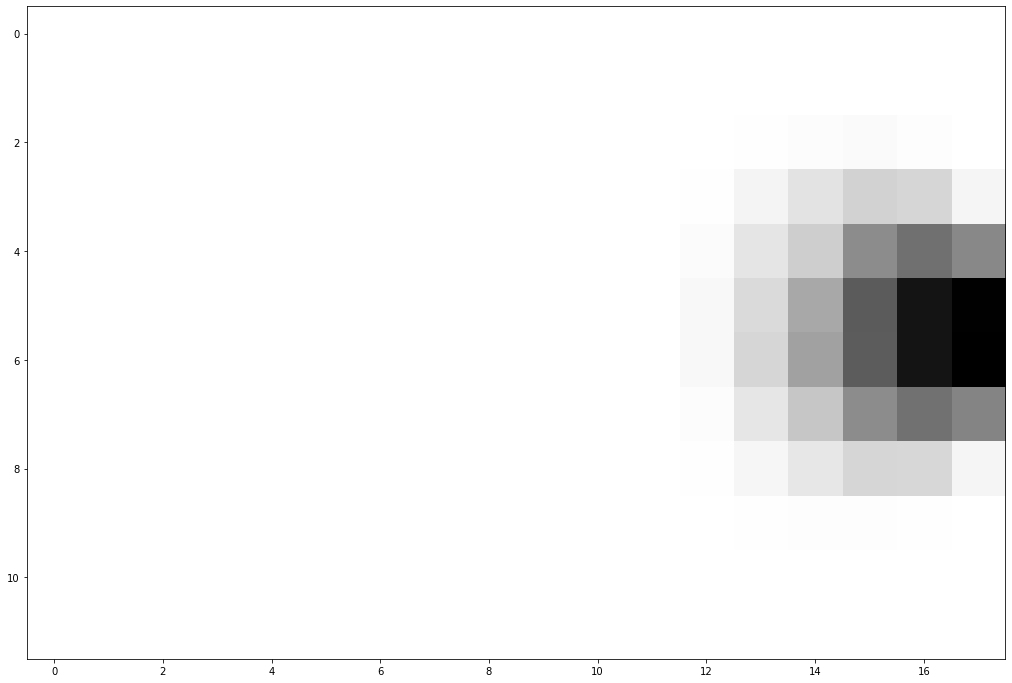

In [13]:
fig = plt.figure(figsize=(18,12))
plt.imshow(pM, interpolation='nearest', cmap=cm.Greys_r)

## 2. Calculating, visualising, and analysing xT **with synthetic shot data**

In [14]:
xT_surface, heatmaps = xT.xT_surface(df_opta, opta_successful_shot_events, opta_failed_shot_events, opta_successful_pass_events, opta_failed_pass_events, opta_successful_dribble_events, opta_failed_dribble_events, 'eventSubType', N, M, 105, 68, 1, df_synthetic)

xT_interp = xT.bilinear_interp_xT(xT_surface)

df_opta['xT'] = xT.apply_xT(df_opta, xT_surface, opta_successful_pass_events, opta_failed_pass_events, opta_successful_dribble_events, opta_failed_dribble_events, N, M, 105, 68, 100, xT_mode = 3)

Calculating xG...
Calculating pShoot & pMove...
Calculating transition matrix...
Calculating xT value surface...
Running 1 iteration of xT...
Running 2 iteration of xT...
Running 3 iteration of xT...
Running 4 iteration of xT...
Running 5 iteration of xT...
Running 6 iteration of xT...
Running 7 iteration of xT...
Running 8 iteration of xT...
Running 9 iteration of xT...
Running 10 iteration of xT...
Running 11 iteration of xT...
Running 12 iteration of xT...
Running 13 iteration of xT...
Running 14 iteration of xT...
Running 15 iteration of xT...
Running 16 iteration of xT...
Running 17 iteration of xT...
Running 18 iteration of xT...
Running 19 iteration of xT...
Running 20 iteration of xT...
Running 21 iteration of xT...
Running 22 iteration of xT...
Running 23 iteration of xT...
Running 24 iteration of xT...
# iterations: 24


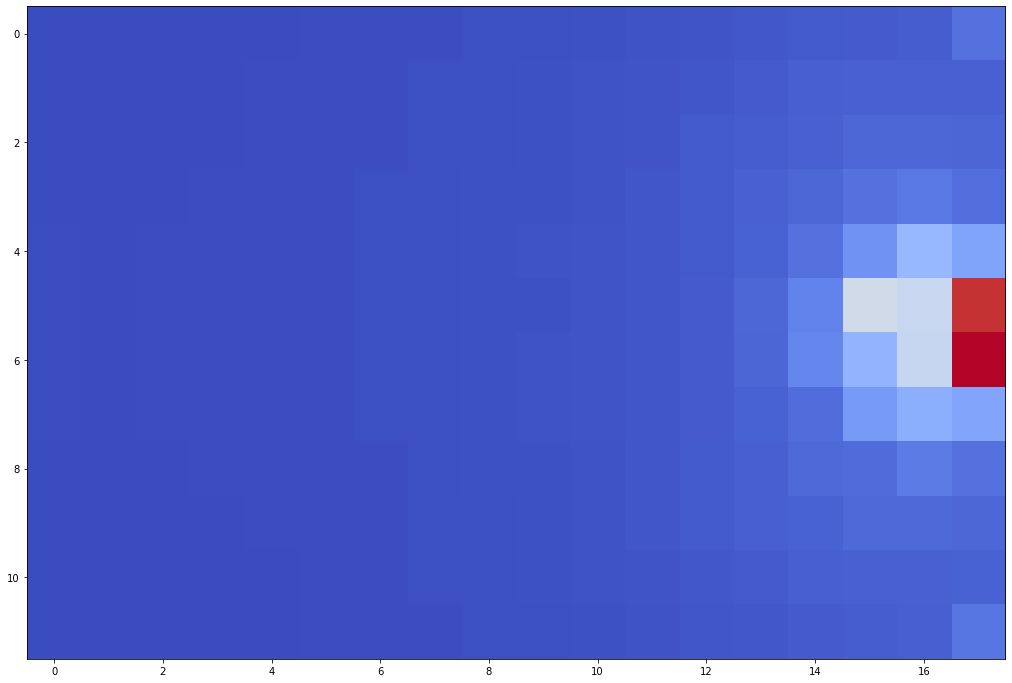

In [15]:
plt.figure(figsize=(18,12))
plt.imshow(xT_surface, interpolation='nearest', cmap=cm.coolwarm)

(-0.5, 1799.5, 1199.5, -0.5)

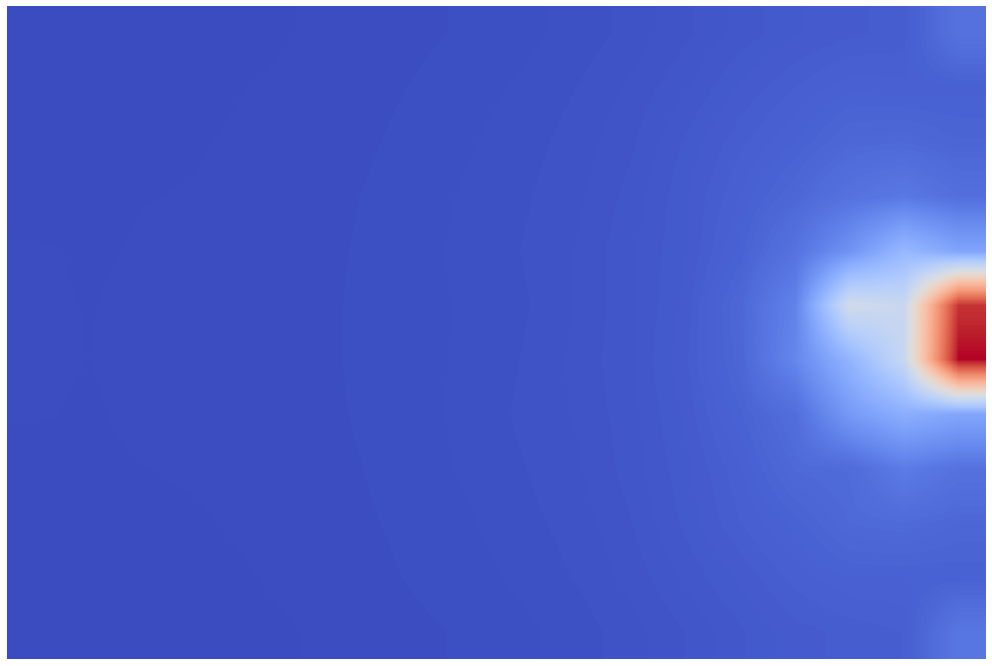

In [16]:
plt.figure(figsize=(18,12))
plt.imshow(xT_interp, interpolation='nearest', cmap=cm.coolwarm)
plt.axis('off')

#plt.savefig(f'bilinear_interp.png', dpi=300, transparent=True)

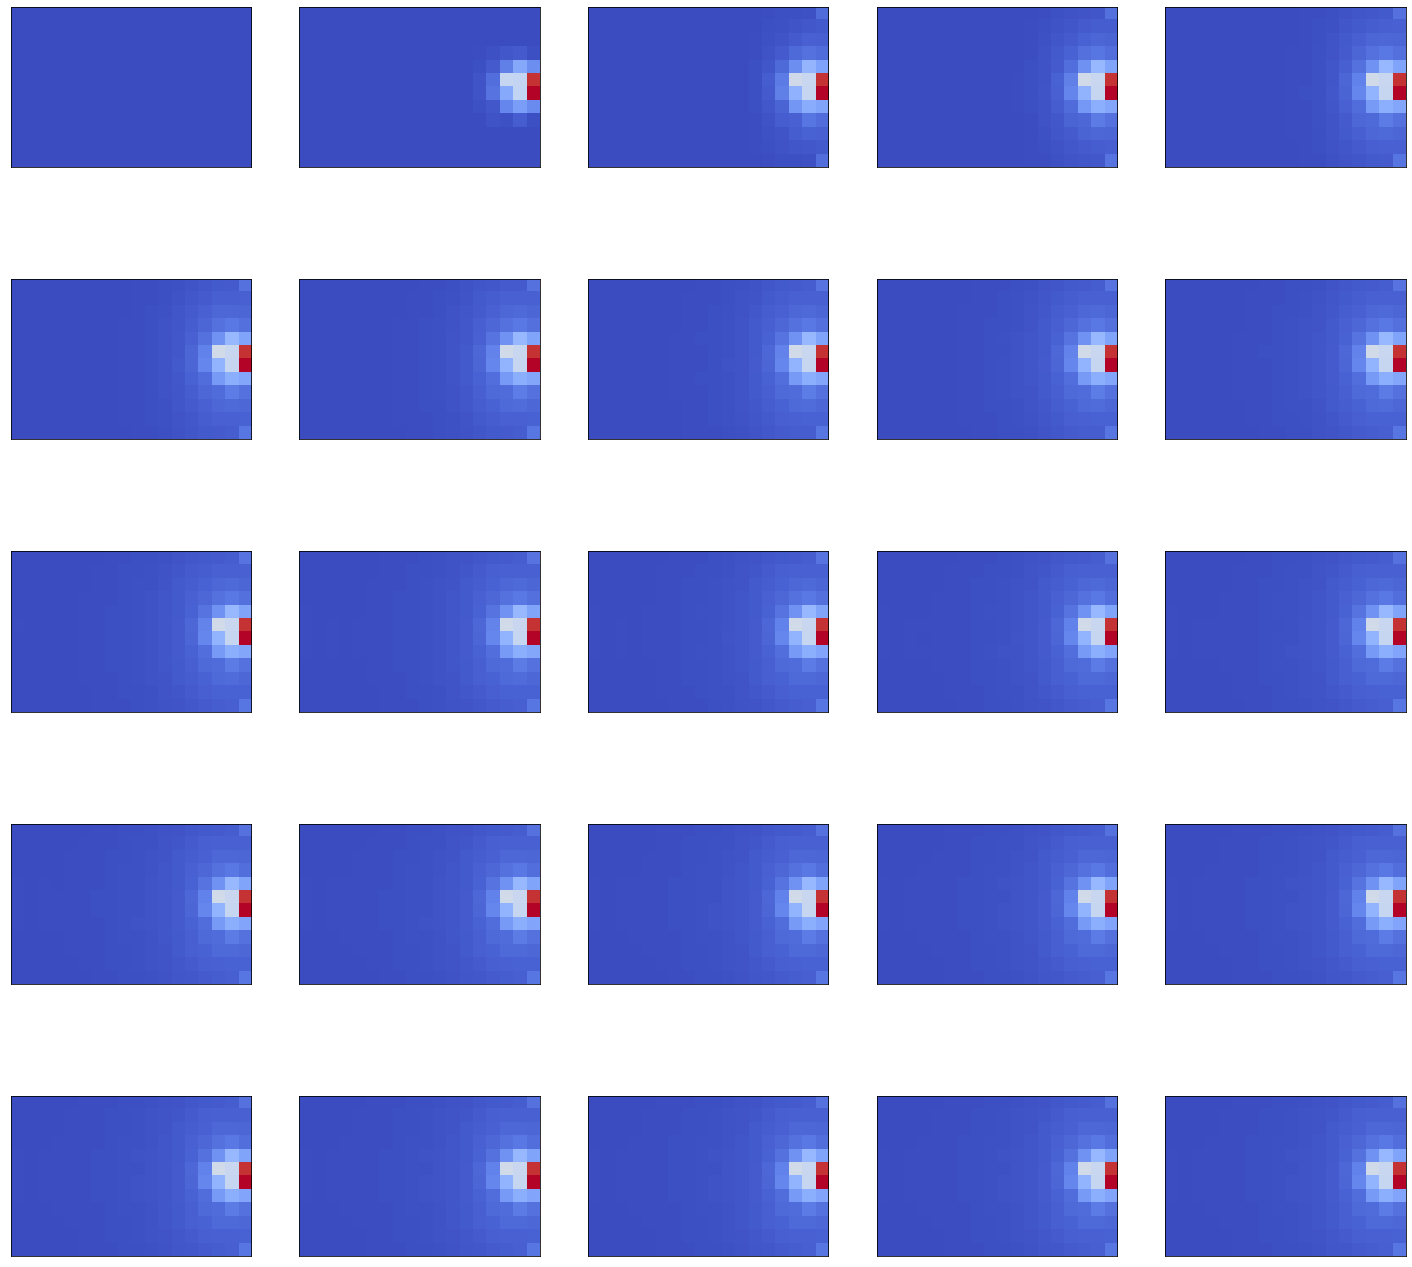

In [17]:
fig, axs = plt.subplots(5,5, figsize=(25, 25), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .01, wspace=.2)

axs = axs.ravel()

for i in range(len(heatmaps)):

    axs[i].imshow(heatmaps[i], interpolation='nearest', cmap=cm.coolwarm)
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)
    
#fig.savefig(f'iterative_solve_xT.png', dpi=300, transparent=True)

---

3. Produce some aggregate metrics per player as part of preliminary analysis

(**Will go into this in far, far more detail in the Interim Report analysis**)

In [22]:
df_xT = df_opta.groupby(['competition','season','playerId','playerName','matchId'])\
        .agg({'xT':np.sum,'minsPlayed':np.mean,'x1':'count'})\
        .reset_index().rename(columns={'x1':'numActions'})\
        .groupby(['competition','season','playerId','playerName'])\
        .agg({'xT':np.sum,'minsPlayed':np.sum,'numActions':np.sum,'matchId':'nunique'})\
        .reset_index()\
        .rename(columns={'matchId':'numMatches'})\
        .sort_values('xT', ascending=False)

df_xT['xT_per_90'] = (df_xT.xT / df_xT.minsPlayed) * 90

# min mins filter
df_xT = df_xT.loc[(df_xT['minsPlayed'] > 1000)]

df_xT['season_xT_rank'] = df_xT.sort_values('xT', ascending=False).groupby(['competition','season']).cumcount() + 1
df_xT['season_xT_per_90_rank'] = df_xT.sort_values('xT_per_90', ascending=False).groupby(['competition','season']).cumcount() + 1

df_xT.loc[df_xT['season_xT_per_90_rank'] <= 20].sort_values(['competition','season','season_xT_per_90_rank'], ascending=[True,True, True])

,competition,season,playerId,playerName,xT,minsPlayed,numActions,numMatches,xT_per_90,season_xT_rank,season_xT_per_90_rank
131,Champions League,2017/18,42593,Aleksandar Kolarov,3.207455,1119,1353,12,0.257972,1,1
365,Champions League,2017/18,92217,Roberto Firmino,0.813051,1074,836,13,0.068133,2,2
31,Champions League,2017/18,17861,Sergio Ramos,0.581736,1029,1161,11,0.050881,3,3
94,Champions League,2017/18,38454,Dejan Lovren,0.379990,1092,1205,12,0.031318,4,4
442,Champions League,2017/18,116535,Alisson,0.229233,1119,505,12,0.018437,5,5
164,Champions League,2017/18,49431,Sven Ulreich,0.170860,1032,435,11,0.014901,6,6
407,Champions League,2017/18,104542,Loris Karius,0.149525,1215,525,13,0.011076,7,7
69,Champions League,2017/18,28411,Keylor Navas,0.115615,1035,345,11,0.010053,8,8
18,Champions League,2017/18,14937,Cristiano Ronaldo,0.051417,1221,701,13,0.003790,9,9
127,Champions League,2017/18,42544,Edin Dzeko,-0.094035,1110,536,12,-0.007624,10,10


# Outputting Data to Analysis Repo


In [20]:
## breaking out into competition specific dataframes
df_epl = df_opta.loc[df_opta['competition'] == 'English Premier League'].copy()
df_cl = df_opta.loc[df_opta['competition'] == 'Champions League'].copy()

In [21]:
df_opta.to_csv(os.path.join(output_data_repo, 'Original_Opta_xT.csv'), index=None)
df_epl.to_csv(os.path.join(output_data_repo, 'Original_EPL_Opta_xT.csv'), index=None)
df_cl.to_csv(os.path.join(output_data_repo, 'Original_CL_Opta_xT.csv'), index=None)